In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[1] "talkingdata-adtracking-fraud-detection"

In [2]:
#create library
library(tidyverse)  #package for maintain import data and export data,making data visualisation, and data modeling
library(ggthemes)  #for visualize data
library(ggmosaic)
library(gridExtra)
library(repr)
library(data.table)
library(DataExplorer)
library(fastDummies)
library(lightgbm)
library(tictoc)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: R6


Attaching package: ‘lightgbm’


The following object is masked from ‘package:dplyr’:

    slice




In [3]:
list.files('../input')

train.sample <- fread('../input/talkingdata-adtracking-fraud-detection/train_sample.csv') #just sample of train data
train <- fread('../input/talkingdata-adtracking-fraud-detection/train.csv') #train data
test.sup <- fread('../input/talkingdata-adtracking-fraud-detection/test_supplement.csv') #additional supplement data for the test
test <- fread('../input/talkingdata-adtracking-fraud-detection/test.csv') #test data

[1] "talkingdata-adtracking-fraud-detection"

# EDA

In [4]:
#paste is function to concantinate multiple input and outputed them in one line
#
print(paste('train.sample:', dim(train.sample)[1], 'Rows and', dim(train.sample)[2], 'Columns'))
print(paste('test.sup:', dim(test.sup)[1], 'Rows and', dim(test.sup)[2], 'Columns'))
print(paste('train:', dim(train)[1], 'Rows and', dim(train)[2], 'Columns'))
print(paste('test:', dim(test)[1], 'Rows and', dim(test)[2], 'Columns'))

[1] "train.sample: 100000 Rows and 8 Columns"
[1] "test.sup: 57537505 Rows and 7 Columns"
[1] "train: 184903890 Rows and 8 Columns"
[1] "test: 18790469 Rows and 7 Columns"


Because of size train so big, we choose to only use train sample data for analyzing.

In [5]:
print('train data')
str(train.sample)
print('test data')
str(test)

[1] "train data"
Classes ‘data.table’ and 'data.frame':	100000 obs. of  8 variables:
 $ ip             : int  87540 105560 101424 94584 68413 93663 17059 121505 192967 143636 ...
 $ app            : int  12 25 12 13 12 3 1 9 2 3 ...
 $ device         : int  1 1 1 1 1 1 1 1 2 1 ...
 $ os             : int  13 17 19 13 1 17 17 25 22 19 ...
 $ channel        : int  497 259 212 477 178 115 135 442 364 135 ...
 $ click_time     : POSIXct, format: "2017-11-07 09:30:38" "2017-11-07 13:40:27" ...
 $ attributed_time: POSIXct, format: NA NA ...
 $ is_attributed  : int  0 0 0 0 0 0 0 0 0 0 ...
 - attr(*, ".internal.selfref")=<externalptr> 
[1] "test data"
Classes ‘data.table’ and 'data.frame':	18790469 obs. of  7 variables:
 $ click_id  : int  0 1 2 3 4 5 6 7 9 8 ...
 $ ip        : int  5744 119901 72287 78477 123080 110769 12540 88637 14932 123701 ...
 $ app       : int  9 9 21 15 12 18 3 27 18 12 ...
 $ device    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ os        : int  3 3 19 13 13 13 1 19 10 53 ...


In [6]:
train_df<-data.frame(train.sample)
head(train_df)%>%print

      ip app device os channel          click_time attributed_time
1  87540  12      1 13     497 2017-11-07 09:30:38            <NA>
2 105560  25      1 17     259 2017-11-07 13:40:27            <NA>
3 101424  12      1 19     212 2017-11-07 18:05:24            <NA>
4  94584  13      1 13     477 2017-11-07 04:58:08            <NA>
5  68413  12      1  1     178 2017-11-09 09:00:09            <NA>
6  93663   3      1 17     115 2017-11-09 01:22:13            <NA>
  is_attributed
1             0
2             0
3             0
4             0
5             0
6             0


In [7]:
test<-test[sample(.N,1e5),]
test_df<-data.frame(test)
head(test_df)%>%print

  click_id     ip app device os channel          click_time
1  8748845 115744   2      1 11     237 2017-11-10 09:51:36
2  5092701 119734  18      1 47     107 2017-11-10 05:35:23
3 11747953 100629  25      1  8     259 2017-11-10 10:49:02
4  7597273  60083  26      1 19     477 2017-11-10 09:27:55
5 18629264 100445  22      1 19     116 2017-11-10 14:57:00
6   552649  10371   9      1 19     107 2017-11-10 04:09:50


from the information, we can see that test data doesn't have is_attributed column. So we can conclude is_attributed is target of this data. There are six feature giving impact to fraudulent and one feature time for time of the fraudulent 

in train data, no click_id column is found in train.sample

In [8]:
test_df<-subset(test_df, select=-click_id)

## missing value ##

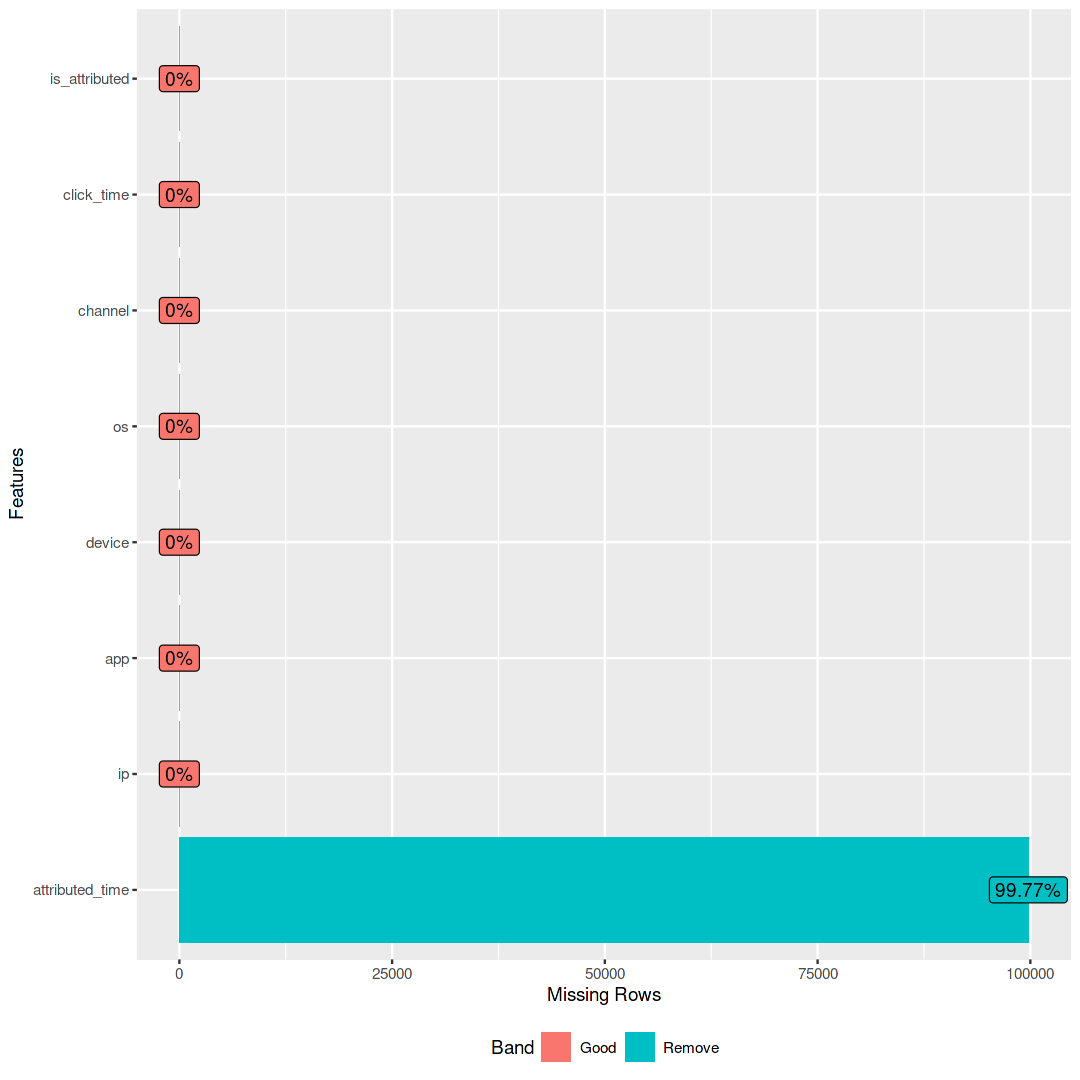

In [9]:
options(repr.plot.width=9, repr.plot.height=9) # resize plot option
plot_missing(train_df)#plot missing value in data

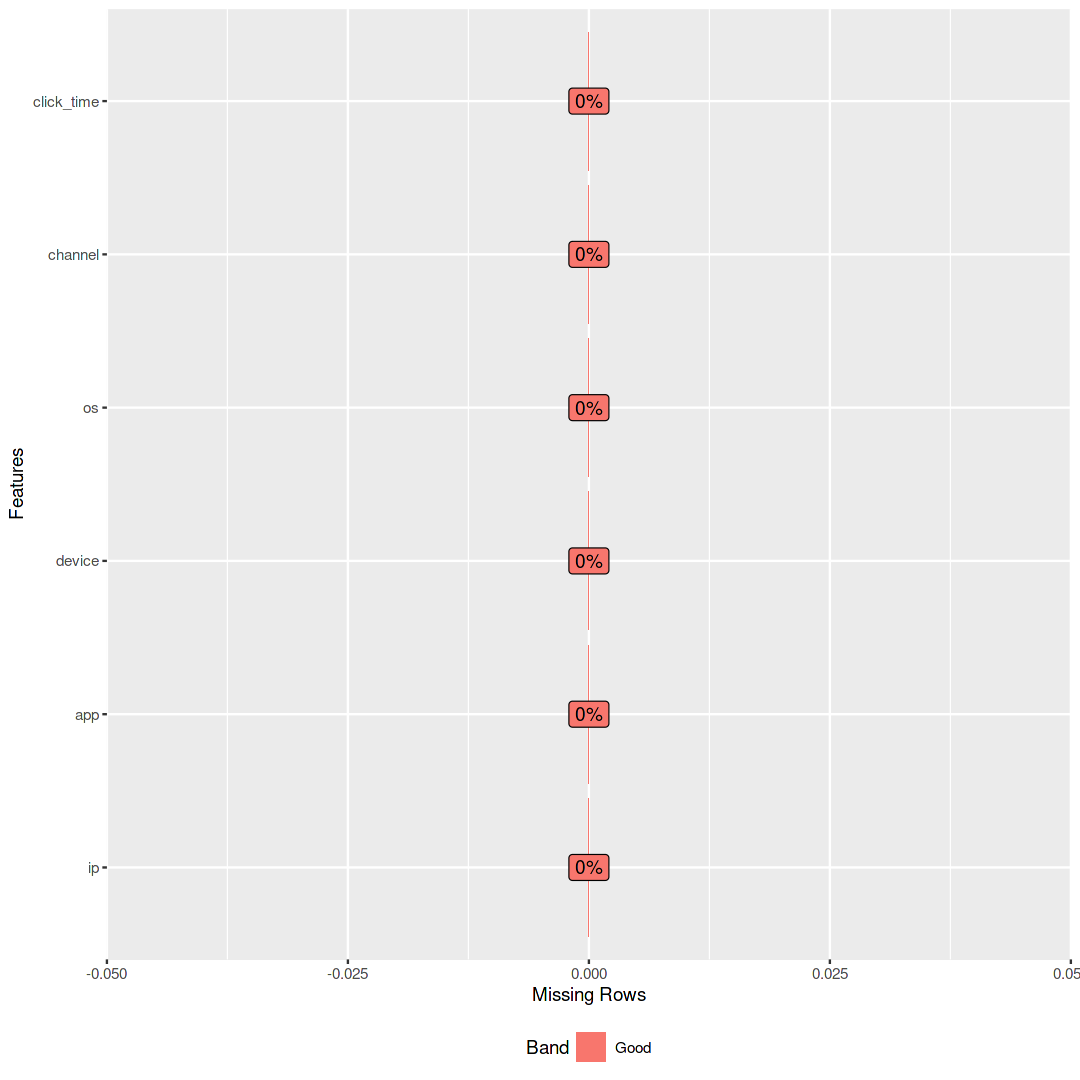

In [10]:
options(repr.plot.width=9, repr.plot.height=9) # resize plot option
plot_missing(test_df)#plot missing value in data

both data don't have any missing value except train data on attribute_time feature that more 99% data is missing. So we should delete this column

In [11]:
train_df <-subset(train_df, select=-attributed_time)
head(train_df) %>% print

      ip app device os channel          click_time is_attributed
1  87540  12      1 13     497 2017-11-07 09:30:38             0
2 105560  25      1 17     259 2017-11-07 13:40:27             0
3 101424  12      1 19     212 2017-11-07 18:05:24             0
4  94584  13      1 13     477 2017-11-07 04:58:08             0
5  68413  12      1  1     178 2017-11-09 09:00:09             0
6  93663   3      1 17     115 2017-11-09 01:22:13             0


## Target: is_attributed##

In [12]:
#making target dataframe
target_df <- data.frame(table(train_df['is_attributed']))
head(target_df)%>%print

  Var1  Freq
1    0 99773
2    1   227


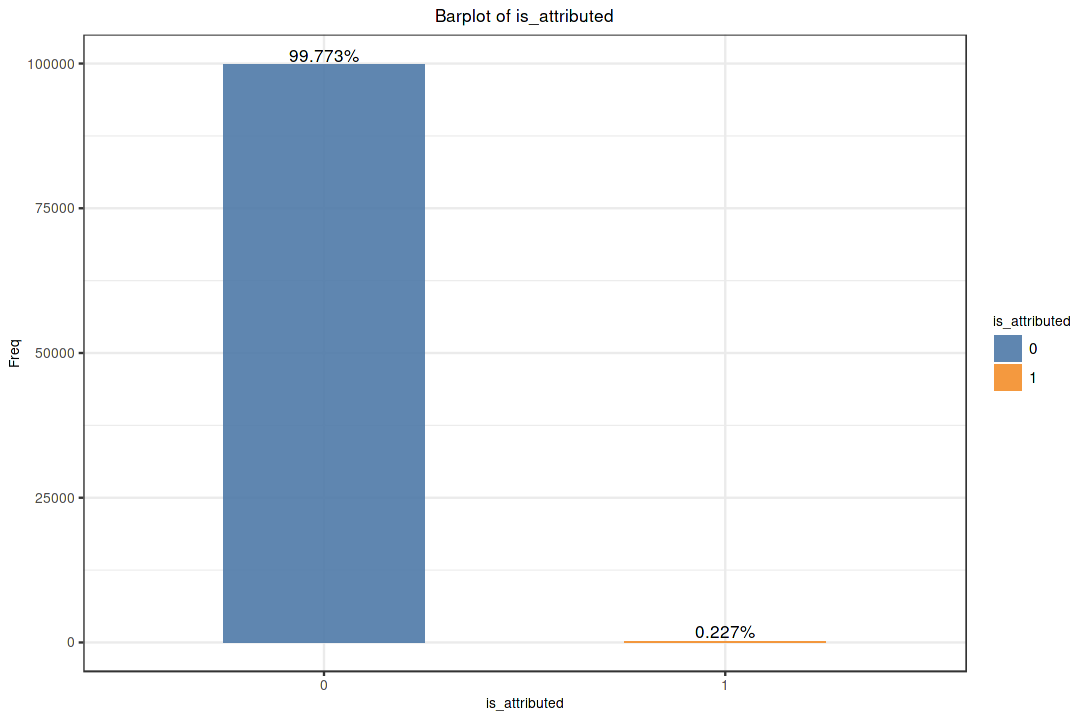

In [13]:
colnames(target_df) <- c("is_attributed", "Freq") #select is_attributed and Freq
options(repr.plot.width=9, repr.plot.height=6) # resize plot option
target_df %>% ggplot(aes(x=is_attributed, y=Freq, fill=is_attributed)) +
    geom_bar(position = 'dodge', stat='identity', alpha=0.9, width=0.5) +
    geom_text(aes(label=paste0(round(Freq/sum(Freq)*100, 3), "%")), position=position_dodge(width=0.9), vjust=-0.25, size=3.5) +
    scale_fill_tableau() +
    theme_bw() + ylim(0, 1e5) +
    ggtitle('Barplot of is_attributed') +
    theme(plot.title = element_text(hjust=0.5, size=10), # centering and setting font size of plot title
          axis.text = element_text(size=8),
          legend.title = element_text(size=8),
          axis.title = element_text(size=8))

WOW significant different between 0 and 1 value

## app

In [14]:
print(paste('maximum value of app is: ',max(train_df$app), 'with minimum value: ',min(train_df$app)))

[1] "maximum value of app is:  551 with minimum value:  1"


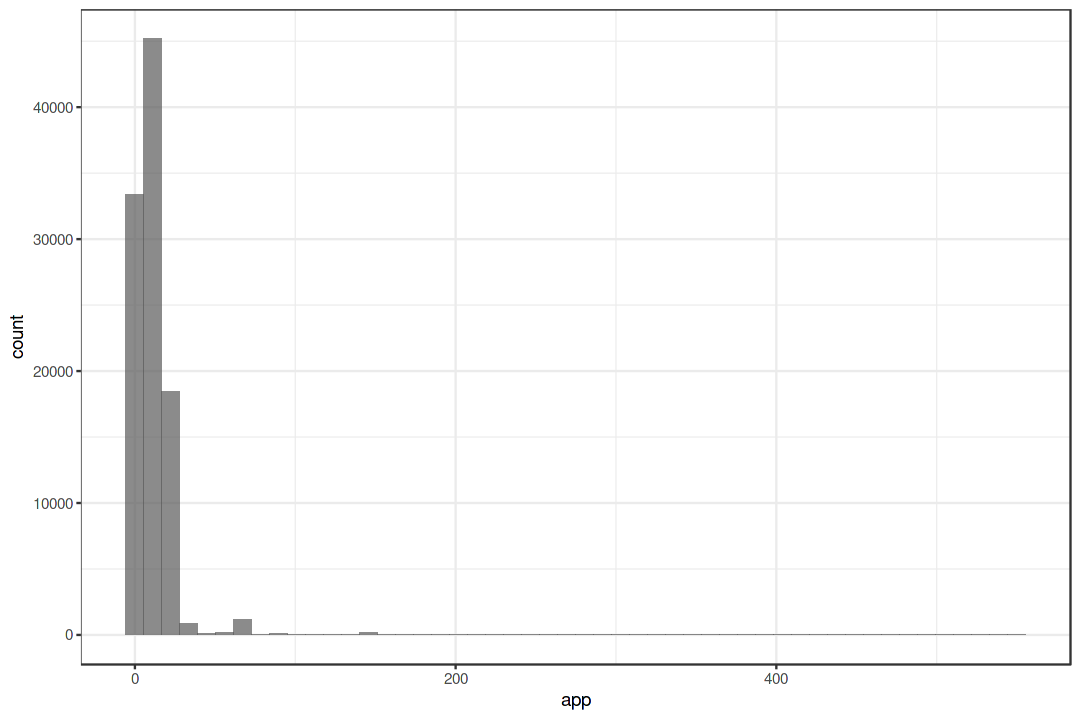

In [15]:
options(repr.plot.width=9, repr.plot.height=6) # resize plot option
train_df %>% ggplot(aes(x= app)) + 
    geom_histogram(alpha=0.7, bins=50) +
    scale_fill_tableau() + theme_bw()

the interval between max and min is so big, and there are many variance, so we should normalize the data using min-max normalization

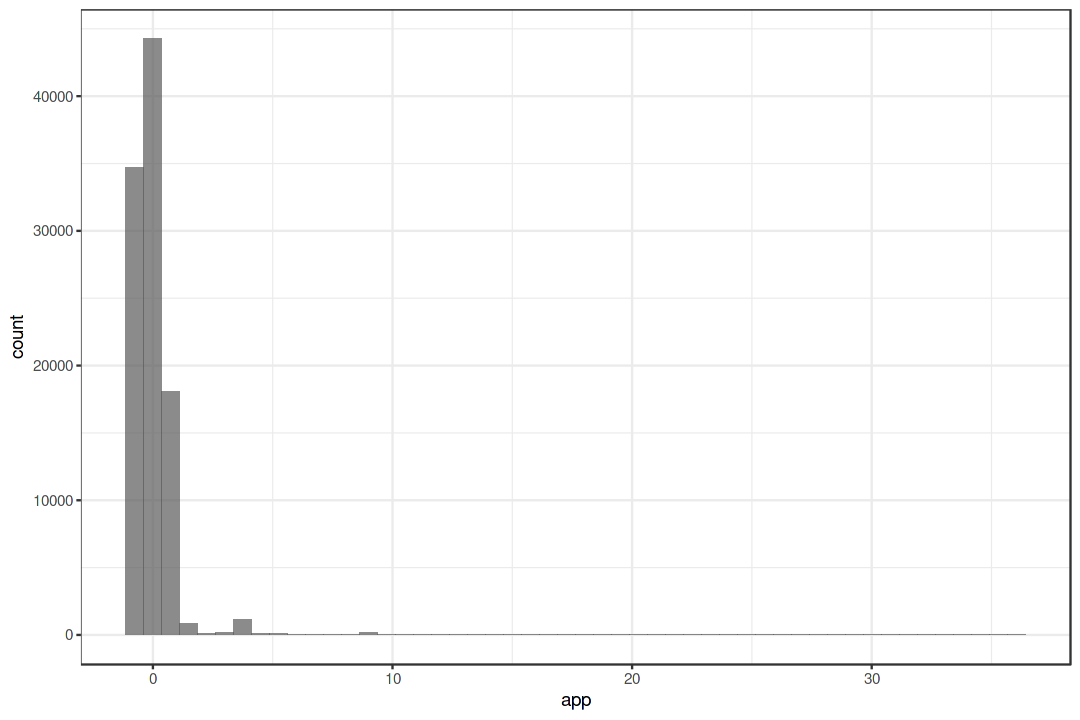

In [16]:
#function for normalizing
min_max_norm <- function(x) {
    (x - min(x)) / (max(x) - min(x))
  }
#norm_app(train_df) <- preProcess(as.data.frame(), method=c("range"))
#train_df$app=as.data.frame(lapply(train_df$app, min_max_norm))
train_df[,2]=scale(train_df[,2])

#plot
options(repr.plot.width=9, repr.plot.height=6) # resize plot option
train_df %>% ggplot(aes(x= app)) + 
    geom_histogram(alpha=0.7, bins=50) +
    scale_fill_tableau() + theme_bw()

In [17]:
print(paste('after normalization, maximum value of app is: ',max(train_df$app), 'with minimum value: ',min(train_df$app)))

[1] "after normalization, maximum value of app is:  36.070817704261 with minimum value:  -0.739409032287601"


## device ##

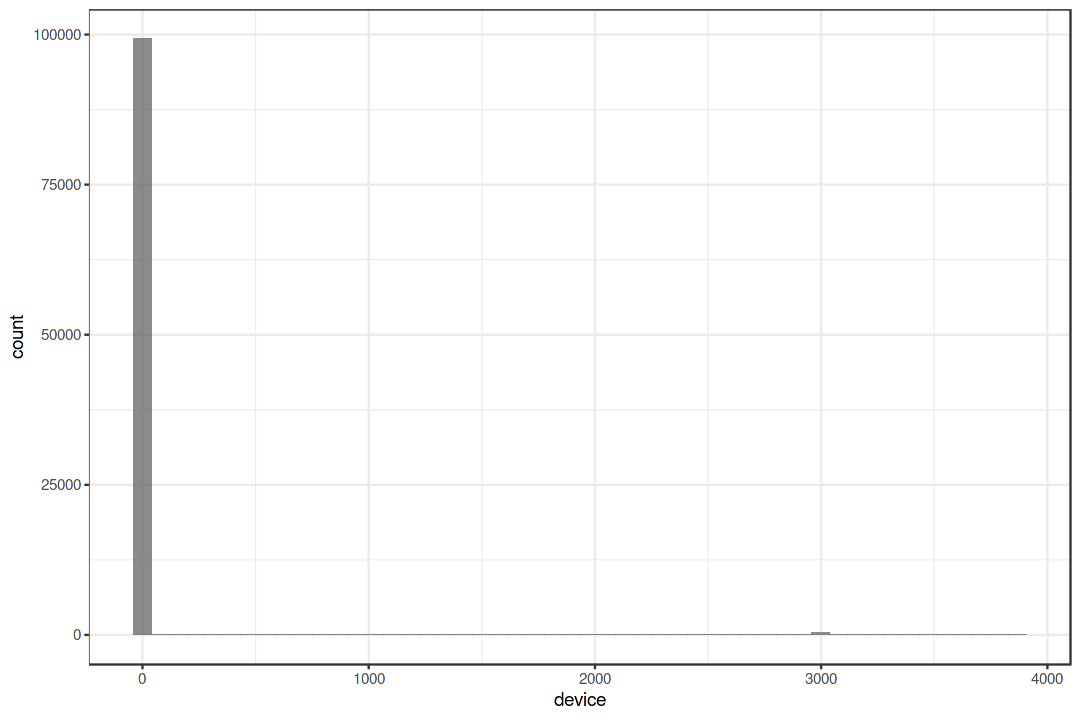

In [18]:
options(repr.plot.width=9, repr.plot.height=6) # resize plot option
train_df %>% ggplot(aes(x= device)) + 
    geom_histogram(alpha=0.7, bins=50) +
    scale_fill_tableau() + theme_bw()

In [19]:
print(paste('min device is: ',min(train_df$device), 'and maximum is: ',max(train_df$device)))

[1] "min device is:  0 and maximum is:  3867"


## Feature Correlation  ##

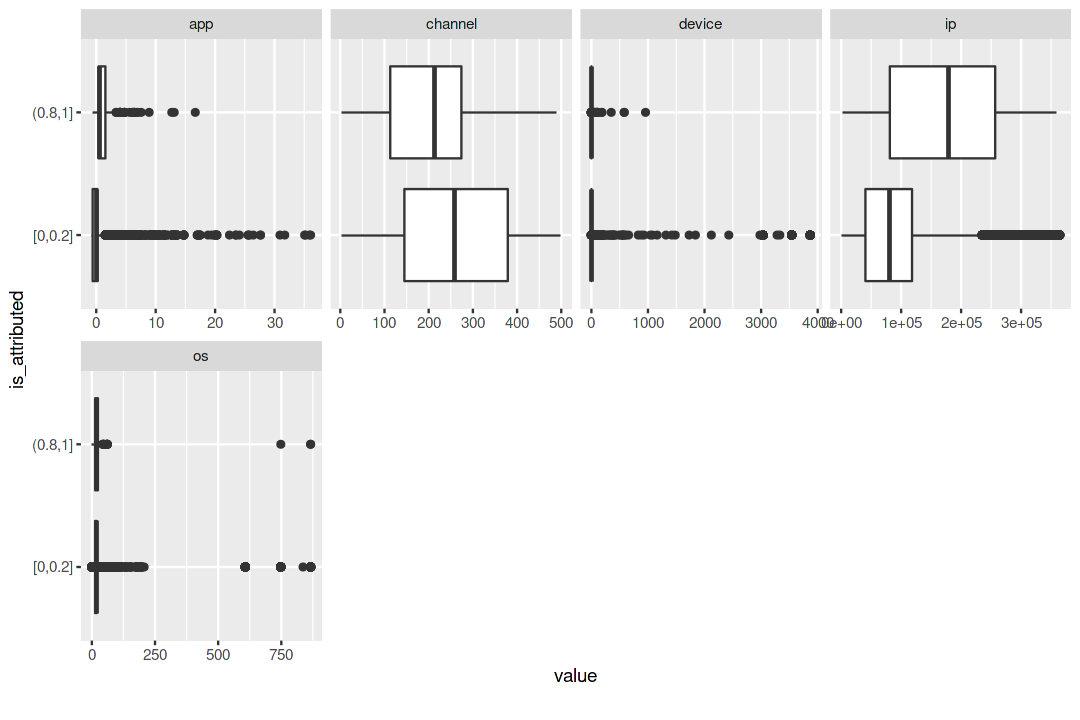

In [20]:
plot_boxplot(train_df, by = "is_attributed")

## time ##

In [21]:
print(paste('min time is: ',min(train_df$click_time), 'and maximum is: ',max(train_df$click_time)))

[1] "min time is:  2017-11-06 16:00:00 and maximum is:  2017-11-09 15:59:51"


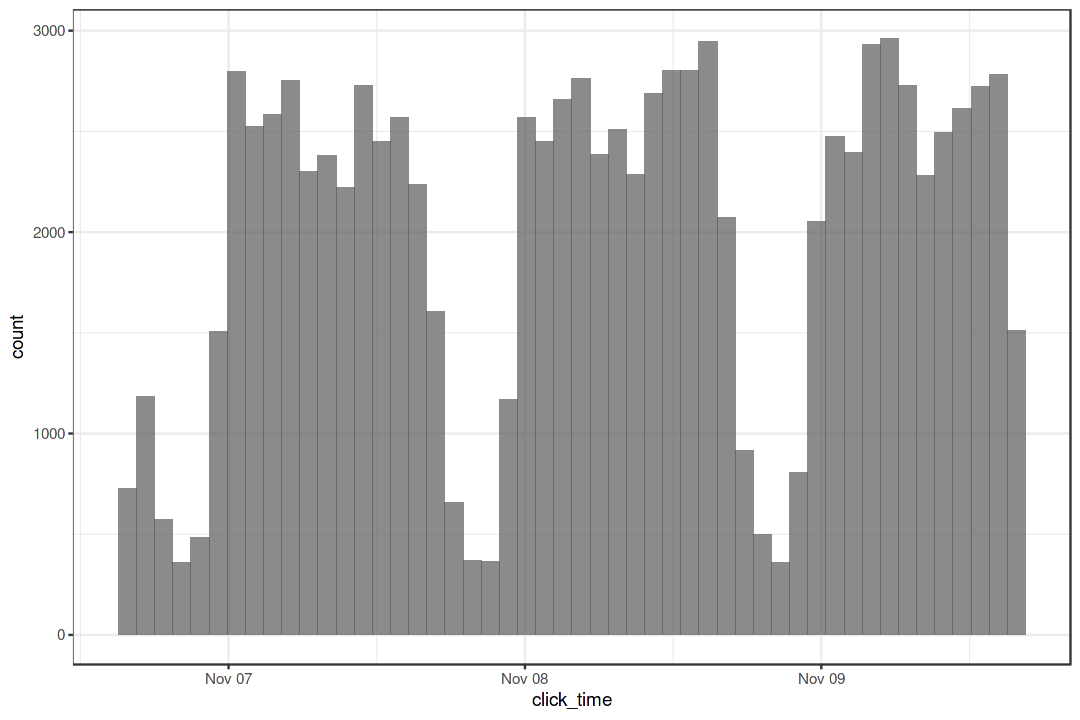

In [22]:
options(repr.plot.width=9, repr.plot.height=6) # resize plot option
train_df %>% ggplot(aes(x= click_time)) + 
    geom_histogram(alpha=0.7, bins=50) +
    scale_fill_tableau() + theme_bw()